# 1. Install important dependencies

In [5]:
# # Install necessary packages
# !pip install transformers nltk datasets numpy seaborn pandas scikit-learn matplotlib
# !pip install torch
# !pip install accelerate>=0.20.1
# !pip install mlxtend
# !pip install tensorflow



# 2. Import Dependencies

In [3]:
import numpy as np
import json
import seaborn as sns
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from mlxtend.plotting import plot_confusion_matrix

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, GlobalMaxPooling1D, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import plot_model
from sklearn.metrics import classification_report
from tensorflow.keras.models import load_model

import warnings
warnings.filterwarnings("ignore")

In [7]:
# tf.__version__


### 2.1 Loading the dataset

In [2]:
df=pd.read_csv("train.csv")


In [3]:
df.head(3)

,Class Index,Title,Description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...


### 2.2 Renaming the Target column "Class Index" as "Labels"

In [4]:

df = df.rename(columns={'Class Index':'Labels'})


### 2.3 Checking for null values

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   Labels       120000 non-null  int64 
 1   Title        120000 non-null  object
 2   Description  120000 non-null  object
dtypes: int64(1), object(2)
memory usage: 2.7+ MB


### Note:
    1) Zero null values in train and test data

### 2.4 Checking each class data count

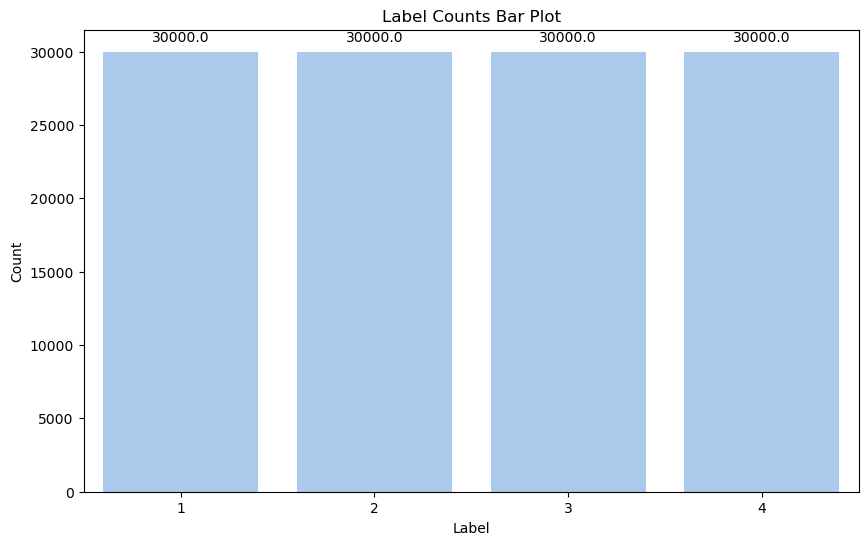

In [6]:
# For train data - checking for unbalanced dataset

value_counts = df['Labels'].value_counts()

# Create a bar plot
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
sns.set_palette("pastel")  # Use a pastel color palette

# Plotting the bar plot
ax = sns.barplot(x=value_counts.index, y=value_counts.values)

# Adding labels and title
ax.set(xlabel='Label', ylabel='Count', title='Label Counts Bar Plot')

# Display the counts on top of the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.show()

#### Note:
     1) Each class contains "30,000" training samples.
     2) The dataset is evenly distributed. Therefore, there is no need for oversampling/undersampling of the classes.


# 3. Data Preprocessing

#### Making changes to the original dataframes
    1) We're being provided with two columns : Title & Description
    2) We obtain most of the information from the title itself.
    3)  So, it's a better choice to merge the title and description columns with the title column being first. And drop Title & Description column

In [7]:
# Merging "Title" and "Description" column.

df['Text'] = df['Title'] + " " + df['Description']


In [8]:
# We no longer needed separate title and description columns so I'll drop them

df = df.drop(['Title', 'Description'], axis=1)


In [9]:
df.head(3)

,Labels,Text
0,3,Wall St. Bears Claw Back Into the Black (Reute...
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters...


In [10]:
# Printing for 3 values of "Text" column

for i in range(0,4):
    print(df['Text'][i])
    print("------------------------------------------")
    print()

Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.
------------------------------------------

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market.
------------------------------------------

Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected to\hang over the stock market next week during the depth of the\summer doldrums.
------------------------------------------

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\flows from the main pipeline in southern Iraq after\intelligence showed a rebel militia could strike\infrastructure, 


#### Changing Class Labels

    # Our dataset has class Labels in the range 1-4
    # The loss calculation that we will be using is "Cross Entropy"
    # If there are 'c' classes, cross entropy expects labels from 0 to c-1
    # we need to decrease all labels by one.

In [11]:
# Changing class Labels from [1, 2, 3, 4] to [0, 1, 2, 3]

df['Labels'] = df['Labels'] - 1


In [12]:
df.head()

,Labels,Text
0,2,Wall St. Bears Claw Back Into the Black (Reute...
1,2,Carlyle Looks Toward Commercial Aerospace (Reu...
2,2,Oil and Economy Cloud Stocks' Outlook (Reuters...
3,2,Iraq Halts Oil Exports from Main Southern Pipe...
4,2,"Oil prices soar to all-time record, posing new..."


In [13]:
df['Labels'].unique()

array([2, 3, 1, 0])

In [14]:
data = df.copy()

#### Remove Punctuations

In [15]:
import re   

In [16]:
# regular expression can be used to remove any punctuation, unnecessary symbols and numbers etc.
import re

def remove_punctuations(text):
    text=re.sub(r'[\\-]',' ',text)
    text=re.sub(r'[,.?;:\'(){}!|0-9]','',text)
    return text

# the apply method applies a function along an axis of dataframe
data['Text']=data['Text'].apply(remove_punctuations)


# re.sub('[^a-zA-Z]', ' ', text)

In [17]:
for i in range(0,4):
    print(data['Text'][i])
    print("------------------------------------------")
    print()

Wall St Bears Claw Back Into the Black Reuters Reuters   Short sellers Wall Streets dwindling band of ultra cynics are seeing green again
------------------------------------------

Carlyle Looks Toward Commercial Aerospace Reuters Reuters   Private investment firm Carlyle Group which has a reputation for making well timed and occasionally controversial plays in the defense industry has quietly placed its bets on another part of the market
------------------------------------------

Oil and Economy Cloud Stocks Outlook Reuters Reuters   Soaring crude prices plus worries about the economy and the outlook for earnings are expected to hang over the stock market next week during the depth of the summer doldrums
------------------------------------------

Iraq Halts Oil Exports from Main Southern Pipeline Reuters Reuters   Authorities have halted oil export flows from the main pipeline in southern Iraq after intelligence showed a rebel militia could strike infrastructure an oil official sai

In [18]:
data['Text'] = data['Text'].apply(lambda x : x.lower())

In [19]:
for i in range(0,4):
    print(data['Text'][i])
    print("------------------------------------------")
    print()

wall st bears claw back into the black reuters reuters   short sellers wall streets dwindling band of ultra cynics are seeing green again
------------------------------------------

carlyle looks toward commercial aerospace reuters reuters   private investment firm carlyle group which has a reputation for making well timed and occasionally controversial plays in the defense industry has quietly placed its bets on another part of the market
------------------------------------------

oil and economy cloud stocks outlook reuters reuters   soaring crude prices plus worries about the economy and the outlook for earnings are expected to hang over the stock market next week during the depth of the summer doldrums
------------------------------------------

iraq halts oil exports from main southern pipeline reuters reuters   authorities have halted oil export flows from the main pipeline in southern iraq after intelligence showed a rebel militia could strike infrastructure an oil official sai

# 4. Exploratory Data Analysis

In [20]:
# Tokenize and fit on texts
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['Text'])

# Get the word counts
words_count = sorted(tokenizer.word_counts.items(), key=lambda x: x[1], reverse=True)

# Display the dictionary of token counts
word_count_dict = dict(words_count)
df_word_count = pd.DataFrame(list(word_count_dict.items()), columns=['Token', 'Count'])
print(df_word_count)

               Token   Count
0                the  205441
1                 to  120707
2                  a  113274
3                 of   98647
4                 in   96416
...              ...     ...
70332           xxxv       1
70333         aceh's       1
70334       quizzing       1
70335  interrogating       1
70336    'offensive'       1

[70337 rows x 2 columns]


In [21]:
# Save the tokenizer's word_index to a JSON file
with open('tokenizer_word_index.json', 'w') as json_file:
    json.dump(tokenizer.word_index, json_file)

In [22]:
df_word_count.head(60)

,Token,Count
0,the,205441
1,to,120707
2,a,113274
3,of,98647
4,in,96416
5,and,69666
6,on,57649
7,for,50669
8,39,44505
9,s,39483


In [23]:
max_words = 10000

In [24]:
# Finding the Maximum and Average length of Text

average_length = df['Text'].apply(lambda x: len(x.split())).mean()
print(f'Average Text Length: {average_length}')

max_length = df['Text'].apply(lambda x: len(x.split())).max()
print(f'Maximum Text Length: {max_length}')


Average Text Length: 37.84461666666667
Maximum Text Length: 177


In [25]:
max_len = 40

# 5. Splitting the training data into train and test data

In [26]:
train_df, test_df = train_test_split(df, test_size=0.3, random_state=42)

In [27]:
(train_df.shape),(test_df.shape)

((84000, 2), (36000, 2))

# 6. Tokenization of train data

In [28]:
# Tokenize the text data
tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(train_df['Text'])


In [29]:
# Convert text to sequences and pad them
train_sequences = tokenizer.texts_to_sequences(train_df['Text'])
train_padded = pad_sequences(train_sequences, maxlen=max_len, padding='post', truncating='post')



In [30]:
train_sequences

[[1491,
  350,
  3,
  2964,
  2751,
  3226,
  1,
  6,
  1922,
  225,
  273,
  137,
  108,
  108,
  2387,
  2107,
  58,
  1,
  23,
  906,
  35,
  1,
  1,
  2107,
  7,
  157,
  3,
  2964,
  2751,
  78,
  993,
  3,
  699,
  3677,
  7,
  1116,
  407,
  135,
  78,
  18,
  2688],
 [1,
  3227,
  239,
  445,
  1015,
  1352,
  1,
  807,
  1,
  310,
  57,
  3,
  369,
  125,
  48,
  78,
  3,
  1139,
  198,
  7,
  136,
  3400,
  1972,
  12,
  21,
  1,
  137,
  5979,
  7,
  460,
  627,
  6,
  16,
  1140],
 [8365,
  429,
  4472,
  356,
  418,
  46,
  256,
  2,
  113,
  1165,
  4472,
  356,
  4291,
  638,
  1421,
  465,
  3333,
  3,
  3333,
  3,
  192,
  27,
  1755,
  161,
  5,
  2,
  517,
  491,
  113,
  2629,
  1,
  1,
  781,
  2,
  491,
  13,
  4,
  987,
  696,
  175,
  35,
  1378,
  1205,
  1,
  1,
  1],
 [1087,
  3731,
  1501,
  1,
  5771,
  1665,
  1712,
  17,
  2,
  317,
  21,
  2597,
  3,
  981,
  9055,
  44,
  868,
  4054,
  164,
  2,
  1,
  2913,
  17,
  2,
  6860,
  1655,
  7158,
  5,
  1,

In [31]:
train_padded

array([[1491,  350,    3, ...,  135,   78,   18],
       [   1, 3227,  239, ...,    0,    0,    0],
       [8365,  429, 4472, ...,  987,  696,  175],
       ...,
       [5939, 1724, 3372, ...,  123,  145,  159],
       [ 368, 4754, 3344, ...,    0,    0,    0],
       [ 347,   10,   11, ...,    0,    0,    0]], dtype=int32)

# 7. Building the LSTM model

In [32]:
# Build the LSTM model
embedding_dim = 32

In [33]:
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len))
model.add(Bidirectional(LSTM(128, return_sequences=True))) # bidirectional LSTMs since this isn't a timeseries problem
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(GlobalMaxPooling1D())
model.add(Dense(1024))
model.add(Dropout(0.25))
model.add(Dense(512))
model.add(Dropout(0.25))
model.add(Dense(256))
model.add(Dropout(0.25))
model.add(Dense(4, activation='softmax'))
model.summary()

2024-01-21 17:06:31.366961: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 40, 32)            320000    
                                                                 
 bidirectional (Bidirection  (None, 40, 256)           164864    
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 40, 128)           164352    
 onal)                                                           
                                                                 
 global_max_pooling1d (Glob  (None, 128)               0         
 alMaxPooling1D)                                                 
                                                                 
 dense (Dense)               (None, 1024)              132096    
                                                        

In [34]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [35]:
# Setting up callbacks (ModelCheckpoint and EarlyStopping)
checkpoint_callback = ModelCheckpoint(filepath='best_model.h5', save_best_only=True, save_weights_only=True, monitor='val_accuracy', mode='max', verbose=1)
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


In [36]:
# Train the model with callbacks and validation
labels_train = train_df['Labels']
history = model.fit(train_padded, labels_train, epochs=20, validation_split=0.2, callbacks=[checkpoint_callback, early_stopping_callback])

Epoch 1/20
2099/2100 [============================>.] - ETA: 0s - loss: 0.3873 - accuracy: 0.8647
Epoch 1: val_accuracy improved from -inf to 0.90363, saving model to best_model.h5
2100/2100 [==============================] - 77s 35ms/step - loss: 0.3873 - accuracy: 0.8647 - val_loss: 0.2883 - val_accuracy: 0.9036
Epoch 2/20
2099/2100 [============================>.] - ETA: 0s - loss: 0.2453 - accuracy: 0.9189
Epoch 2: val_accuracy did not improve from 0.90363
2100/2100 [==============================] - 72s 34ms/step - loss: 0.2453 - accuracy: 0.9189 - val_loss: 0.2914 - val_accuracy: 0.9023
Epoch 3/20
2100/2100 [==============================] - ETA: 0s - loss: 0.1985 - accuracy: 0.9338
Epoch 3: val_accuracy improved from 0.90363 to 0.90446, saving model to best_model.h5
2100/2100 [==============================] - 72s 34ms/step - loss: 0.1985 - accuracy: 0.9338 - val_loss: 0.2802 - val_accuracy: 0.9045
Epoch 4/20
2099/2100 [============================>.] - ETA: 0s - loss: 0.1569 - 

# 8. Evaluating the model on test data

In [37]:
# Evaluating the model on the test set
test_sequences = tokenizer.texts_to_sequences(test_df['Text'])
test_padded = pad_sequences(test_sequences, maxlen=max_len, padding='post', truncating='post')

In [38]:
labels_test = test_df['Labels']
loss, accuracy = model.evaluate(test_padded, labels_test)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

1125/1125 [==============================] - 14s 12ms/step - loss: 0.2883 - accuracy: 0.9062
Test Accuracy: 90.62%


### Note:
    Accuracy on test data is 90.62%

In [39]:
from sklearn.metrics import classification_report, confusion_matrix

In [40]:
# Step 9: Classification Report and Confusion Matrix
predictions = model.predict(test_padded)
predicted_labels = predictions.argmax(axis=1)

print("\nClassification Report:")
print(classification_report(labels_test, predicted_labels))

print("\nConfusion Matrix:")
print(confusion_matrix(labels_test, predicted_labels))

1125/1125 [==============================] - 15s 12ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.89      0.91      8932
           1       0.96      0.96      0.96      9096
           2       0.85      0.90      0.87      8943
           3       0.88      0.88      0.88      9029

    accuracy                           0.91     36000
   macro avg       0.91      0.91      0.91     36000
weighted avg       0.91      0.91      0.91     36000


Confusion Matrix:
[[7909  260  428  335]
 [ 124 8746  140   86]
 [ 270   51 8004  618]
 [ 203   51  811 7964]]


In [50]:
from tensorflow.keras.models import save_model

save_model(model, 'lstm_model.h5')

In [51]:
model

In [52]:
history

# 9. Loading model